# Multi-Agent Research System

This notebook combines all the previous components into a single system.

Here is our overall research flow:

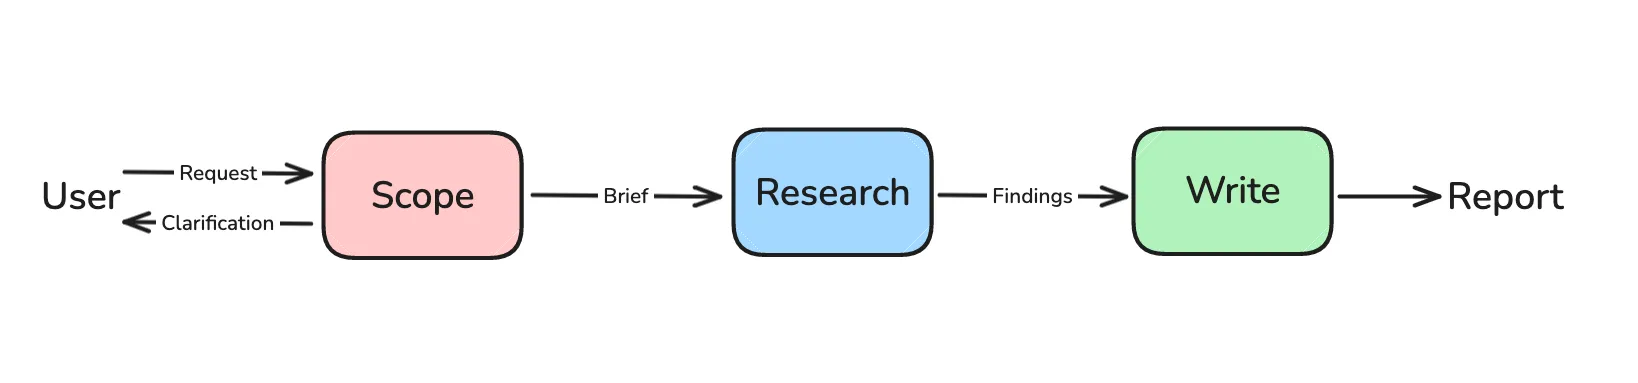

We've covered 
1. **Scoping** - The goal of scoping is to gather user-context needed for research.
2. **Multi-Agent Research** - Delegate research tasks to an appropriate number of sub-agents.

Let's let's combine scoping and multi-agent research togther with our final step, **Writing**.

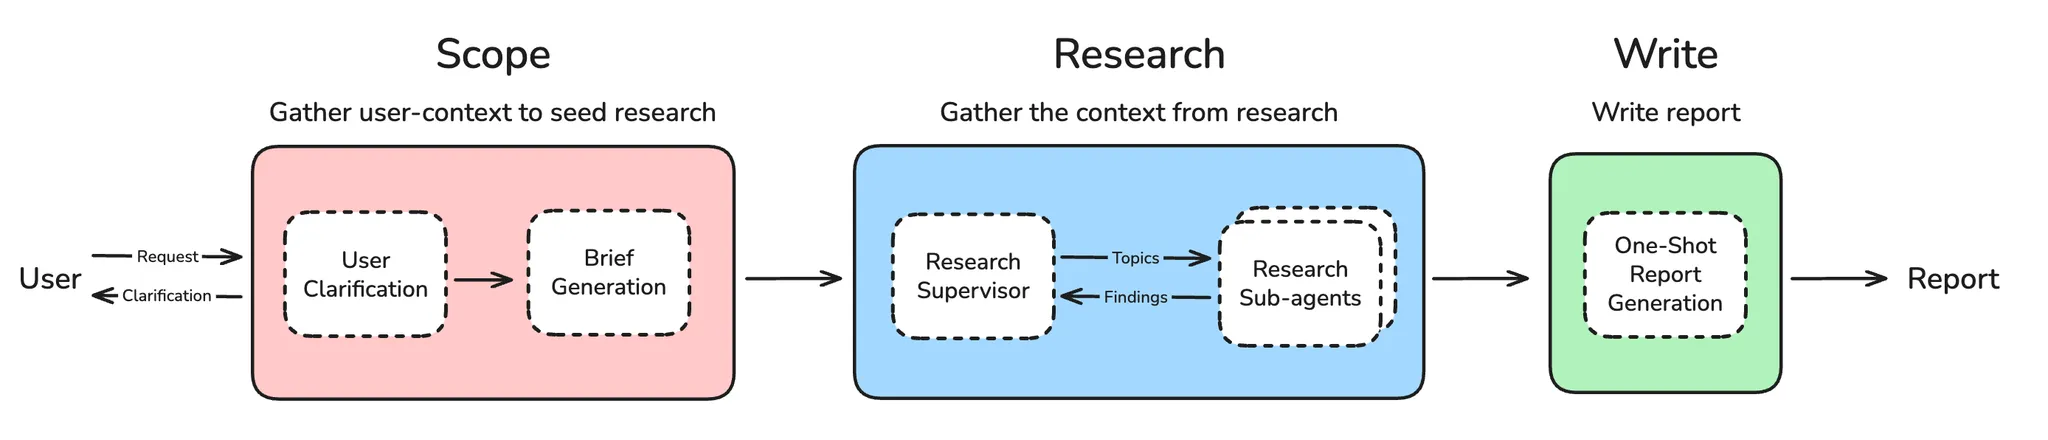

## State and Schemas

In [1]:
%%writefile ../src/deep_research_from_scratch/state_full_agent.py

import operator
from typing import Optional, Annotated, TypedDict
from pydantic import BaseModel, Field
from langgraph.graph import MessagesState
from langchain_core.messages import MessageLikeRepresentation

def override_reducer(current_value, new_value):
    """
    Custom state reducer for flexible state updates.
    
    Allows either additive updates (default) or complete override of state values.
    When new_value is a dict with {"type": "override", "value": data}, 
    the existing state is replaced with the new value.
    Otherwise, new values are added to existing state using operator.add.
    """
    if isinstance(new_value, dict) and new_value.get("type") == "override":
        return new_value.get("value", new_value)
    else:
        return operator.add(current_value, new_value)

class AgentInputState(MessagesState):
    """Input state for the full agent - only contains messages from user input."""
    pass

class AgentState(MessagesState):
    """
    Main state for the full multi-agent research system.
    
    Extends MessagesState with additional fields for research coordination.
    Note: Some fields are duplicated across different state classes for proper
    state management between subgraphs and the main workflow.
    """
    supervisor_messages: Annotated[list[MessageLikeRepresentation], operator.add]
    research_brief: Optional[str]
    
    # Research output fields - these are duplicated in AgentState to capture
    # the final outputs from the supervisor subgraph for report generation
    raw_notes: Annotated[list[str], override_reducer] = []
    notes: Annotated[list[str], override_reducer] = []
    final_report: str

class ClarifyWithUser(BaseModel):
    """Schema for user clarification decisions during scoping phase."""
    need_clarification: bool = Field(
        description="Whether the user needs to be asked a clarifying question.",
    )
    question: str = Field(
        description="A question to ask the user to clarify the report scope",
    )
    verification: str = Field(
        description="Verify message that we will start research after the user has provided the necessary information.",
    )

class ResearchQuestion(BaseModel):
    """Schema for research brief generation."""
    research_brief: str = Field(
        description="A research question that will be used to guide the research.",
    )

class SupervisorState(TypedDict):
    """State for supervisor subgraph that coordinates research agents."""
    supervisor_messages: Annotated[list[MessageLikeRepresentation], operator.add]
    research_brief: str
    notes: Annotated[list[str], override_reducer] = []
    research_iterations: int = 0
    raw_notes: Annotated[list[str], override_reducer] = []

class ResearcherState(TypedDict):
    """State for individual researcher agents."""
    researcher_messages: Annotated[list[MessageLikeRepresentation], operator.add]
    tool_call_iterations: int = 0
    research_topic: str
    compressed_research: str
    raw_notes: Annotated[list[str], override_reducer] = []

class ResearcherOutputState(BaseModel):
    """Output schema for researcher subgraph."""
    compressed_research: str
    raw_notes: Annotated[list[str], override_reducer] = []

class ConductResearch(BaseModel):
    """Tool schema for supervisor to delegate research tasks."""
    research_topic: str = Field(
        description="The topic to research. Should be a single topic, and should be described in high detail (at least a paragraph).",
    )

class ResearchComplete(BaseModel):
    """Tool schema for supervisor to indicate research completion."""
    pass

Overwriting ../src/deep_research_from_scratch/state_full_agent.py


### Agent 

Now, we'll define our agent.

In [2]:
%%writefile ../src/deep_research_from_scratch/research_agent_full.py

"""
Full Multi-Agent Research System

This module integrates all components of the research system:
- User clarification and scoping
- Research brief generation  
- Multi-agent research coordination
- Final report generation

The system orchestrates the complete research workflow from initial user
input through final report delivery.
"""

import asyncio
from datetime import datetime
from typing_extensions import Literal

import nest_asyncio
from langchain.chat_models import init_chat_model
from langchain_core.messages import (
    HumanMessage, MessageLikeRepresentation, filter_messages, 
    SystemMessage, ToolMessage, get_buffer_string, AIMessage
)
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.types import Command

from deep_research_from_scratch.utils import tavily_search
from deep_research_from_scratch.prompts import (
    clarify_with_user_instructions, transform_messages_into_research_topic_prompt,
    final_report_generation_prompt, research_agent_prompt, compress_research_system_prompt, lead_researcher_prompt
)
from deep_research_from_scratch.state_full_agent import (
    AgentState, AgentInputState, ClarifyWithUser, ResearchQuestion, SupervisorState, 
    ResearcherState, ResearcherOutputState, ConductResearch, ResearchComplete
)

# ===== UTILITY FUNCTIONS =====

def get_today_str() -> str:
    """Get current date in a human-readable format."""
    return datetime.now().strftime("%a %b %-d, %Y")

def get_notes_from_tool_calls(messages: list[MessageLikeRepresentation]) -> list[str]:
    """Extract content from tool messages in the conversation history."""
    return [tool_msg.content for tool_msg in filter_messages(messages, include_types="tool")]

# ===== CONFIGURATION =====

# Enable nested event loops for Jupyter
nest_asyncio.apply()

# Initialize models
scoping_model = init_chat_model(model="openai:gpt-4.1")
writer_model = init_chat_model(model="openai:gpt-4.1")

# Initialize researcher model and tools
researcher_tools = [tavily_search]
researcher_tools_by_name = {tool.name: tool for tool in researcher_tools}
researcher_model = init_chat_model(model="openai:gpt-4.1")
researcher_model_with_tools = researcher_model.bind_tools(researcher_tools)

# Initialize supervisor model and tools
supervisor_tools = [ConductResearch, ResearchComplete]
supervisor_model = init_chat_model(model="openai:gpt-4.1")
supervisor_model_with_tools = supervisor_model.bind_tools(supervisor_tools)

# System constants
# Maximum number of tool call iterations for individual researcher agents
# This prevents infinite loops and controls research depth per topic
max_researcher_iterations = 3

# Maximum number of concurrent research agents the supervisor can launch
# This is passed to the lead_researcher_prompt to limit parallel research tasks
max_concurrent_researchers = 3

# ===== SCOPING WORKFLOW NODES =====

def clarify_with_user(state: AgentState) -> Command[Literal["write_research_brief", "__end__"]]:
    """
    Clarification decision node.
    
    Determines if the user's request contains sufficient information to proceed
    with research or if additional clarification is needed.
    """
    # Set up structured output model
    structured_output_model = scoping_model.with_structured_output(ClarifyWithUser)

    # Invoke the model with clarification instructions
    response = structured_output_model.invoke([
        HumanMessage(content=clarify_with_user_instructions.format(
            messages=get_buffer_string(messages=state["messages"]), 
            date=get_today_str()
        ))
    ])
    
    # Route based on clarification need
    if response.need_clarification:
        return Command(
            goto=END, 
            update={"messages": [AIMessage(content=response.question)]}
        )
    else:
        return Command(
            goto="write_research_brief", 
            update={"messages": [AIMessage(content=response.verification)]}
        )

def write_research_brief(state: AgentState):
    """
    Research brief generation node.
    
    Transforms the conversation history into a comprehensive research brief
    that will guide the subsequent research phase.
    """
    # Set up structured output model
    structured_output_model = scoping_model.with_structured_output(ResearchQuestion)
    
    # Generate research brief from conversation history
    response = structured_output_model.invoke([
        HumanMessage(content=transform_messages_into_research_topic_prompt.format(
            messages=get_buffer_string(state.get("messages", [])),
            date=get_today_str()
        ))
    ])
    
    # Update state with generated research brief
    return {
        "research_brief": response.research_brief,
    }

# ===== RESEARCHER NODES =====

def researcher_llm_call(state: ResearcherState):
    """
    Researcher LLM decision node.
    
    The researcher decides whether to call tools based on the current conversation state.
    """
    result = researcher_model_with_tools.invoke(
        [SystemMessage(content=research_agent_prompt)] + state["researcher_messages"]
    )
    
    # Update state directly (no Command object)
    return {
        "researcher_messages": [result],
        "tool_call_iterations": state.get("tool_call_iterations", 0) + 1
    }

def researcher_tool_node(state: ResearcherState):
    """
    Researcher tool execution node.
    
    Executes tool calls concurrently and updates state with results.
    """
    tool_calls = state["researcher_messages"][-1].tool_calls
    
    async def execute_tools():
        """Execute all tool calls concurrently for better performance."""
        coros = []
        for tool_call in tool_calls:
            tool = researcher_tools_by_name[tool_call["name"]]
            coros.append(tool.ainvoke(tool_call["args"]))
        
        # Execute all tool calls concurrently
        observations = await asyncio.gather(*coros)
        
        # Create tool message outputs
        tool_outputs = [
            ToolMessage(
                content=observation,
                name=tool_call["name"],
                tool_call_id=tool_call["id"]
            ) for observation, tool_call in zip(observations, tool_calls)
        ]
        
        return tool_outputs
    
    # Run async function in sync context with nested event loop support
    tool_outputs = asyncio.run(execute_tools())

    # Update state directly (no Command object)
    return {"researcher_messages": tool_outputs}

def researcher_should_continue(state: ResearcherState) -> Literal["researcher_tool_node", "compress_research"]:
    """
    Conditional routing function for researcher.
    
    Determines whether to continue research or proceed to compression
    based on iteration limits and tool calls.
    """
    messages = state["researcher_messages"]
    last_message = messages[-1]
    
    # Check if we should compress research
    should_compress = (
        state.get("tool_call_iterations", 0) >= max_researcher_iterations or 
        not last_message.tool_calls
    )
    
    if should_compress:
        return "compress_research"
    
    # Continue research if tools were called
    if last_message.tool_calls:
        return "researcher_tool_node"
    
    return "compress_research"

async def compress_research(state: ResearcherState):
    """
    Research compression node.
    
    Summarizes and compresses the research findings into a concise report
    while preserving all raw notes for reference.
    """
    response = await researcher_model.ainvoke([
        SystemMessage(content=compress_research_system_prompt.format(date=get_today_str())),
        *state.get("researcher_messages", [])
    ])
    
    return {
        "compressed_research": str(response.content),
        "raw_notes": ["\n".join([
            str(m.content) for m in filter_messages(
                state["researcher_messages"], 
                include_types=["tool", "ai"]
            )
        ])]
    }

# ===== SUPERVISOR NODES =====

async def supervisor(state: SupervisorState) -> Command[Literal["supervisor_tools"]]:
    """
    Supervisor decision node.
    
    The supervisor coordinates research activities by deciding what research
    to conduct and when the research process is complete.
    """
    supervisor_messages = state.get("supervisor_messages", [])
    research_brief = state.get("research_brief", "")
    
    # Make decision about next research steps
    system_message = lead_researcher_prompt.format(date=get_today_str(), max_concurrent_research_units=max_concurrent_researchers)
    response = await supervisor_model_with_tools.ainvoke([SystemMessage(content=system_message), HumanMessage(content=research_brief)] + supervisor_messages)
    
    return Command(
        goto="supervisor_tools",
        update={
            "supervisor_messages": [response],
            "research_iterations": state.get("research_iterations", 0) + 1
        }
    )

async def supervisor_tools(state: SupervisorState) -> Command[Literal["supervisor", "__end__"]]:
    """
    Supervisor tool execution node.
    
    Executes supervisor decisions by either launching research sub-agents
    or terminating the research process based on completion criteria.
    """
    supervisor_messages = state.get("supervisor_messages", [])
    research_iterations = state.get("research_iterations", 0)
    most_recent_message = supervisor_messages[-1]
    
    # Check exit criteria
    exceeded_allowed_iterations = research_iterations >= max_researcher_iterations
    no_tool_calls = not most_recent_message.tool_calls
    research_complete_tool_call = any(
        tool_call["name"] == "ResearchComplete" 
        for tool_call in most_recent_message.tool_calls
    )
    
    if exceeded_allowed_iterations or no_tool_calls or research_complete_tool_call:
        return Command(
            goto=END,
            update={
                "notes": get_notes_from_tool_calls(supervisor_messages),
                "research_brief": state.get("research_brief", "")
            }
        )
    
    # Launch parallel research sub-agents
    try:
        conduct_research_calls = [
            tool_call for tool_call in most_recent_message.tool_calls 
            if tool_call["name"] == "ConductResearch"
        ]
        
        # Create concurrent research tasks
        coros = [
            researcher_subgraph.ainvoke({
                "researcher_messages": [
                    HumanMessage(content=tool_call["args"]["research_topic"])
                ],
                "research_topic": tool_call["args"]["research_topic"]
            }) 
            for tool_call in conduct_research_calls
        ]
        
        # Wait for all research to complete
        tool_results = await asyncio.gather(*coros)
        
        # Format results as tool messages for supervisor
        tool_messages = [
            ToolMessage(
                content=observation.get("compressed_research", "Error synthesizing research report"),
                name=tool_call["name"],
                tool_call_id=tool_call["id"]
            ) for observation, tool_call in zip(tool_results, conduct_research_calls)
        ]
        
        return Command(
            goto="supervisor",
            update={
                "supervisor_messages": tool_messages,
                "raw_notes": ["\n".join([
                    "\n".join(observation.get("raw_notes", [])) 
                    for observation in tool_results
                ])]
            }
        )
        
    except Exception as e:
        print(f"Error in supervisor tools: {e}")
        return Command(
            goto=END,
            update={
                "notes": get_notes_from_tool_calls(supervisor_messages),
                "research_brief": state.get("research_brief", "")
            }
        )

# ===== FINAL REPORT GENERATION =====

async def final_report_generation(state: AgentState):
    """
    Final report generation node.
    
    Synthesizes all research findings into a comprehensive final report
    and clears intermediate notes from state using override_reducer.
    """
    notes = state.get("notes", [])
    
    # Use override_reducer to clear intermediate notes after final report generation
    cleared_state = {"notes": {"type": "override", "value": []}}
    
    findings = "\n".join(notes)

    final_report_prompt = final_report_generation_prompt.format(
        research_brief=state.get("research_brief", ""),
        findings=findings,
        date=get_today_str()
    )
    
    final_report = await writer_model.ainvoke([HumanMessage(content=final_report_prompt)])
    
    return {
        "final_report": final_report.content, 
        "messages": [final_report],
        **cleared_state
    }

# ===== GRAPH CONSTRUCTION =====

# Build researcher subgraph
researcher_subgraph = StateGraph(ResearcherState, output_schema=ResearcherOutputState)

# Add researcher nodes
researcher_subgraph.add_node("researcher_llm_call", researcher_llm_call)
researcher_subgraph.add_node("researcher_tool_node", researcher_tool_node)
researcher_subgraph.add_node("compress_research", compress_research)

# Add researcher edges
researcher_subgraph.add_edge(START, "researcher_llm_call")
researcher_subgraph.add_conditional_edges(
    "researcher_llm_call",
    researcher_should_continue,
    {
        "researcher_tool_node": "researcher_tool_node",
        "compress_research": "compress_research",
    },
)
researcher_subgraph.add_edge("researcher_tool_node", "researcher_llm_call")  # Loop back
researcher_subgraph.add_edge("compress_research", END)

# Compile researcher subgraph
researcher_subgraph = researcher_subgraph.compile()

# Build supervisor subgraph
supervisor_builder = StateGraph(SupervisorState)

# Add supervisor nodes
supervisor_builder.add_node("supervisor", supervisor)
supervisor_builder.add_node("supervisor_tools", supervisor_tools)

# Add supervisor edges
supervisor_builder.add_edge(START, "supervisor")

# Compile supervisor subgraph
supervisor_subgraph = supervisor_builder.compile()

# Build the overall workflow
deep_researcher_builder = StateGraph(AgentState, input_schema=AgentInputState)

# Add workflow nodes
deep_researcher_builder.add_node("clarify_with_user", clarify_with_user)
deep_researcher_builder.add_node("write_research_brief", write_research_brief)
deep_researcher_builder.add_node("supervisor_subgraph", supervisor_subgraph)
deep_researcher_builder.add_node("final_report_generation", final_report_generation)

# Add workflow edges
deep_researcher_builder.add_edge(START, "clarify_with_user")
deep_researcher_builder.add_edge("write_research_brief", "supervisor_subgraph")
deep_researcher_builder.add_edge("supervisor_subgraph", "final_report_generation")
deep_researcher_builder.add_edge("final_report_generation", END)

# Compile the full workflow
agent = deep_researcher_builder.compile()

Overwriting ../src/deep_research_from_scratch/research_agent_full.py


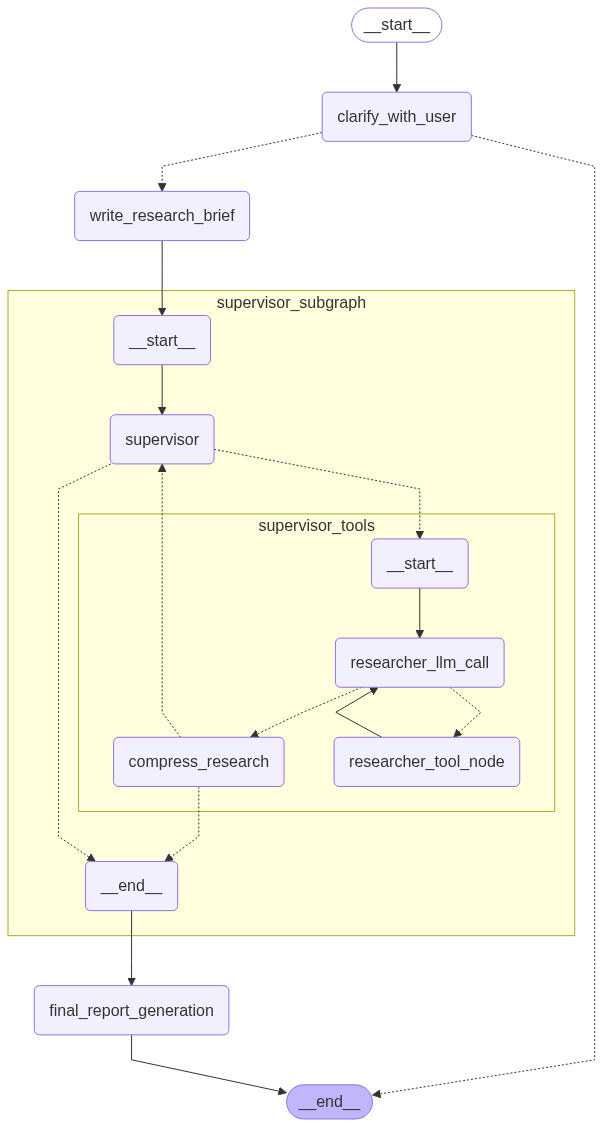

In [3]:
%load_ext autoreload
%autoreload 2

# Run the workflow
from utils import format_messages
from IPython.display import Image, display
from langgraph.checkpoint.memory import InMemorySaver
from deep_research_from_scratch.research_agent_full import deep_researcher_builder

checkpointer = InMemorySaver()
deep_researcher_ntbk_testing = deep_researcher_builder.compile(checkpointer=checkpointer)
display(Image(deep_researcher_ntbk_testing.get_graph(xray=True).draw_mermaid_png()))

In [4]:
from langchain_core.messages import HumanMessage
thread = {"configurable": {"thread_id": "1"}}
result = await deep_researcher_ntbk_testing.ainvoke({"messages": [HumanMessage(content="I want to research the best coffee shops in San Francisco.")]}, config=thread)
format_messages(result['messages'])

Task clarify_with_user with path ('__pregel_pull', 'clarify_with_user') wrote to unknown channel branch:to:__end__, ignoring it.


╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to research the best coffee shops in San Francisco.                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you specify what criteria are most important to you when determining the 'best' coffee shops? (e.g.,      │
│ quality of coffee, ambiance, availability of Wi-Fi, food options, location, etc.) If you have a preferred       │
│ neighborhood or style (third wave, cozy, trendy), please let me know.                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [5]:
result = await deep_researcher_ntbk_testing.ainvoke({"messages": [HumanMessage(content="Let's examine coffee quality to assess the best coffee shops in San Francisco.")]}, config=thread)
format_messages(result['messages'])

Task supervisor_tools with path ('__pregel_pull', 'supervisor_tools') wrote to unknown channel branch:to:__end__, ignoring it.


╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to research the best coffee shops in San Francisco.                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you specify what criteria are most important to you when determining the 'best' coffee shops? (e.g.,      │
│ quality of coffee, ambiance, availability of Wi-Fi, food options, location, etc.) If you have a preferred       │
│ neighborhood or style (third wave, cozy, trendy), please let me know.                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Let's examine coffee quality to assess the best coffee shops in San Francisco.                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Thank you for clarifying that you would like to assess the best coffee shops in San Francisco based solely on   │
│ coffee quality. I now have sufficient information to begin the research process and will focus specifically on  │
│ identifying the top coffee shops in San Francisco known for their exceptional coffee quality.                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ # The Best Coffee Shops in San Francisco for Coffee Quality (2025)                                              │
│                                                                                                                 │
│ ## Overview                                                                                                     │
│                                                                                                                 │
│ This report assesses the leading coffee shops in San Francisco purely based on the quality of their coffee.     │
│ Evaluation focuses on bean sourcing, roast profile, brewing technique, consistency, and taste. All insights     │
│ derive from official shop materials, top industry publications, barista competitions, and expert reviews.       │
│ Ambiance, food, and other non-coffee factors have been excluded.                                                │
│                                                                                                                 │
│ ## Criteria for Evaluation                                                                                      │
│                                                                                                                 │
│ - **Bean Sourcing:** Focus on direct, ethical, and transparent sourcing, engagement with specialty producers,   │
│ and traceability.                                                                                               │
│ - **Roast Profile:** Approaches to roasting (light, medium, dark), how these highlight bean characteristics,    │
│ and consistency.                                                                                                │
│ - **Brewing Technique:** Barista skill, equipment, manual vs. automated methods, and innovation in preparation. │
│ - **Consistency and Taste:** Awards, expert tasting notes, and recurring positive ratings for flavor, clarity,  │
│ and overall coffee experience.                                                                                  │
│ - **Professional Recognition:** Competition results, third-party reviews, national/international accolades.     │
│                                                                                                                 │
│ ## Top San Francisco Coffee Shops for Coffee Quality                                                            │
│                                                                                                                 │
│ ### 1. Saint Frank Coffee                                                                                       │
│                                                                                                                 │
│ - **Bean Sourcing:** Maintains direct, ethical relationships with producers in Bolivia, Colombia, Kenya, and    │
│ Guatemala. Commits to sustainability and transparency, frequently showcasing microlots. Sourcing directly       │
│ supports coffee communities and emphasizes traceable, high-quality green coffee [1].                            │
│ - **Roast Profile:** Light-roast focus to preserve nuance, floral, citrus, and origin-driven brightness.        │
│ Roasting tailored to highlight each bean’s innate character rather than imposing roast-driven flavors [1].      │
│ - **Brewing Technique:** Team of highly trained baristas execute manual pour-overs and precise espresso         │
│ extractions, ensuring flavor clarity and consistency [1].                                                       │
│ - **Consistency and Taste:** Nationally acclaimed for clean, vibrant cups with sophisticated acidity and        │
│ balance. Frequently scores above 90 on Coffee Review and lauded for its transparent approach from seed to cup   │
│ [1,2].                                                 

In [6]:
from rich.markdown import Markdown
Markdown(result["final_report"])

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                        The Best Coffee Shops in San Francisco for Coffee Quality (2025)                         ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


                                                     Overview                                                      

This report assesses the leading coffee shops in San Francisco purely based on the quality of their coffee.        
Evaluation focuses on bean sourcing, roast profile, brewing technique, consistency, and taste. All insights derive 
from official shop materials, top industry publications, barista competitions, and expert reviews. Ambiance, food, 
and other non-coffee factors have been excluded.                                                                   


                                              Criteria for Evaluation                                              

 • Bean Sourcing: Focus on direct, ethical, and transparent sourcing, engagement with specialty producers, and     
   traceability.                                                                                                   
 • Roast Profile: Approaches to roasting (light, medium, dark), how these highlight bean characteristics, and      
   consistency.                                                                                                    
 • Brewing Technique: Barista skill, equipment, manual vs. automated methods, and innovation in preparation.       
 • Consistency and Taste: Awards, expert tasting notes, and recurring positive ratings for flavor, clarity, and    
   overall coffee experience.                                                                                      
 • Professional Recognition: Competition results, third-party reviews, national/international accolades.           


                                 Top San Francisco Coffee Shops for Coffee Quality                                 

                                               1. Saint Frank Coffee                                               

 • Bean Sourcing: Maintains direct, ethical relationships with producers in Bolivia, Colombia, Kenya, and          
   Guatemala. Commits to sustainability and transparency, frequently showcasing microlots. Sourcing directly       
   supports coffee communities and emphasizes traceable, high-quality green coffee [1].                            
 • Roast Profile: Light-roast focus to preserve nuance, floral, citrus, and origin-driven brightness. Roasting     
   tailored to highlight each bean’s innate character rather than imposing roast-driven flavors [1].               
 • Brewing Technique: Team of highly trained baristas execute manual pour-overs and precise espresso extractions,  
   ensuring flavor clarity and consistency [1].                                                                    
 • Consistency and Taste: Nationally acclaimed for clean, vibrant cups with sophisticated acidity and balance.     
   Frequently scores above 90 on Coffee Review and lauded for its transparent approach from seed to cup [1,2].     
 • Professional Recognition: Finalist (3rd place, Jason Yeo) at the 2025 US Barista Championship, regular high-tier
   expert reviews, and ranked among top three coffee shops nationally by multiple industry authorities [3,4,5].    
 • Summary: Saint Frank exemplifies specialty coffee excellence, combining traceable sourcing and exceptional      
   execution with national barista recognition and outstanding taste [1,3].                                        

                                              2. The Coffee Movement                                               

 • Bean Sourcing: Rotating menu of seasonal lots from world-class roasters and international origins, with a strong
   focus on single origin and freshness. Col

### LangGraph Studio

Just as we did before, we can also use LangGraph Studio to visualize the agent. 

This agent has been added to the `langgraph.json` file, so you can select `research_agent_full` in the dropdown menu:

```
"research_agent_full": "./src/deep_research_from_scratch/research_agent_full.py:agent"
```

Run the following command to start the studio

```bash
uvx --refresh --from "langgraph-cli[inmem]" --with-editable . --python 3.11 langgraph dev --allow-blocking
```

### Eval (TODO: @nick Add e2e)

* General criteria (but this doesn't feel that useful tbh)
* Pairwise against other model providers

## Lesson (TODO: @geoff)

### Evals

Try adding your own eval examples andperform end to end evals.